# Wave signal processing

### This notebook will take you through computing wave spectra from the displacement data available on your SD card. It starts with the "displacement.csv" file that is generated when you use the Spotter SD card parsing script, available here (https://github.com/sofarocean/spotter-sd-parser).

In [1]:
import pandas as pd
from wave_signal_processing.spectral_analysis import *
from wave_signal_processing.bulk_parameters import compute_bulk_parameters
from utils.utils import format_csv_time

# put the path to your own data directory here
data_dir = '/Users/annasavage/Documents/sd-card-data/smart_drifter/drift_test/32252_drifter/log/'

In [2]:
displacement = pd.read_csv(data_dir + 'displacement.csv')
displacement['time'] = format_csv_time(displacement)

szz = pd.read_csv(data_dir + 'Szz.csv')
szz['time'] = format_csv_time(szz)

(-3.0, 3.0)

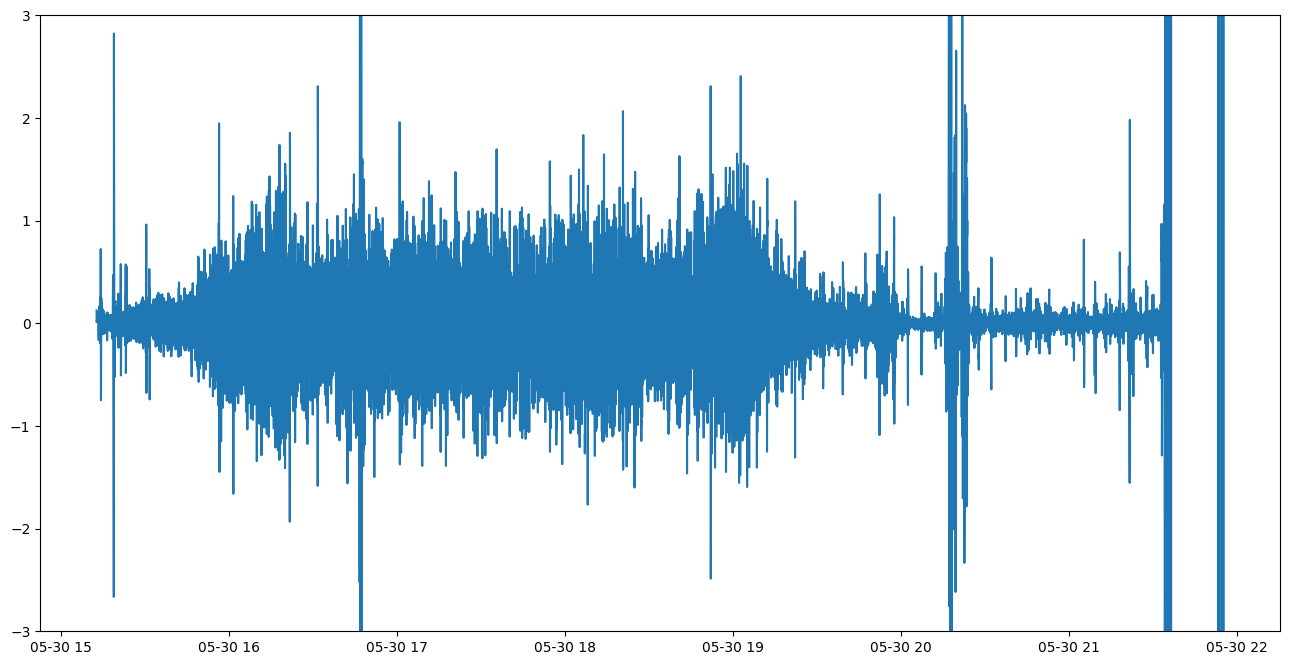

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16, 8))

plt.plot(displacement['time'], displacement[' z(m)'])
plt.ylim([-3, 3])

The next cell computes wave spectra over the same time series that Spotter uses to compute wave spectra in nearly an identical fashion. Spotter wave spectra go through a cross correlation correction to further reduce the effect of low-frequency noise, and this correction is not possible with the data available on the SD card. As a result, you will likely see some differences between the recomputed wave spectra and the spectra from the SD card at low-frequencies, and also in the recomputed bulk parameters, which are computed from the spectral densities.

This spectral calculation utilizes scipy's Welch method, which ingests a time series, computes spectral densities over overlapping segmented time series of length N, and then returns the average of the computed spectral densities. As written below, the "compute_full_spectra_from_displacement" function will generate wave spectra in nearly exactly the same way that Spotter does, but there is optionality to change several of the underlying variables. For example, a user can change the value of N, which will change the frequency resolution of the returned spectra. A user can also modify "segment_length_seconds", which is the number of seconds over which to compute one full spectral estimate. On Spotter, this is either 30 or 60 minutes.

In [4]:
for t, time in enumerate(szz['time']):
    if t == 0:
        diff = displacement[displacement['time'] <= szz['time'][t]]
    else:
        diff = displacement[(displacement['time'] > szz['time'][t-1]) & (displacement['time'] <= szz['time'][t])]

    disp = Displacement(x = diff[' x (m)'].astype('float').to_numpy(), y = diff[' y(m)'].astype('float').to_numpy(), z = diff[' z(m)'].astype('float').to_numpy(), time = diff['time'].to_numpy())
    if t == 0:
        spec = compute_full_spectra_from_displacement(disp, fs=2.5, N=256, segment_length_seconds=len(diff)/2.5)
    else:
        spec.append(compute_full_spectra_from_displacement(disp, fs=2.5, N=256, segment_length_seconds=len(diff)/2.5))

In [10]:
# read in all of the spectra from the SD card computed on the Spotter.

qxz_sd = pd.read_csv(data_dir + 'Qxz.csv')
cxy_sd = pd.read_csv(data_dir + 'Cxy.csv')
qyz_sd = pd.read_csv(data_dir + 'Qyz.csv')
exx_sd = pd.read_csv(data_dir + 'Sxx.csv')
eyy_sd = pd.read_csv(data_dir + 'Syy.csv')
ezz_sd = pd.read_csv(data_dir + 'Szz.csv')

qxz_arr = np.array(qxz_sd).astype('float')
cxy_arr = np.array(cxy_sd).astype('float')
qyz_arr = np.array(qyz_sd).astype('float')
exx_arr = np.array(exx_sd).astype('float')
eyy_arr = np.array(eyy_sd).astype('float')
ezz_arr = np.array(ezz_sd).astype('float')

Text(0.5, 0.98, 'Spectral Comparison for 2025-05-30T18:12:48.400000000')

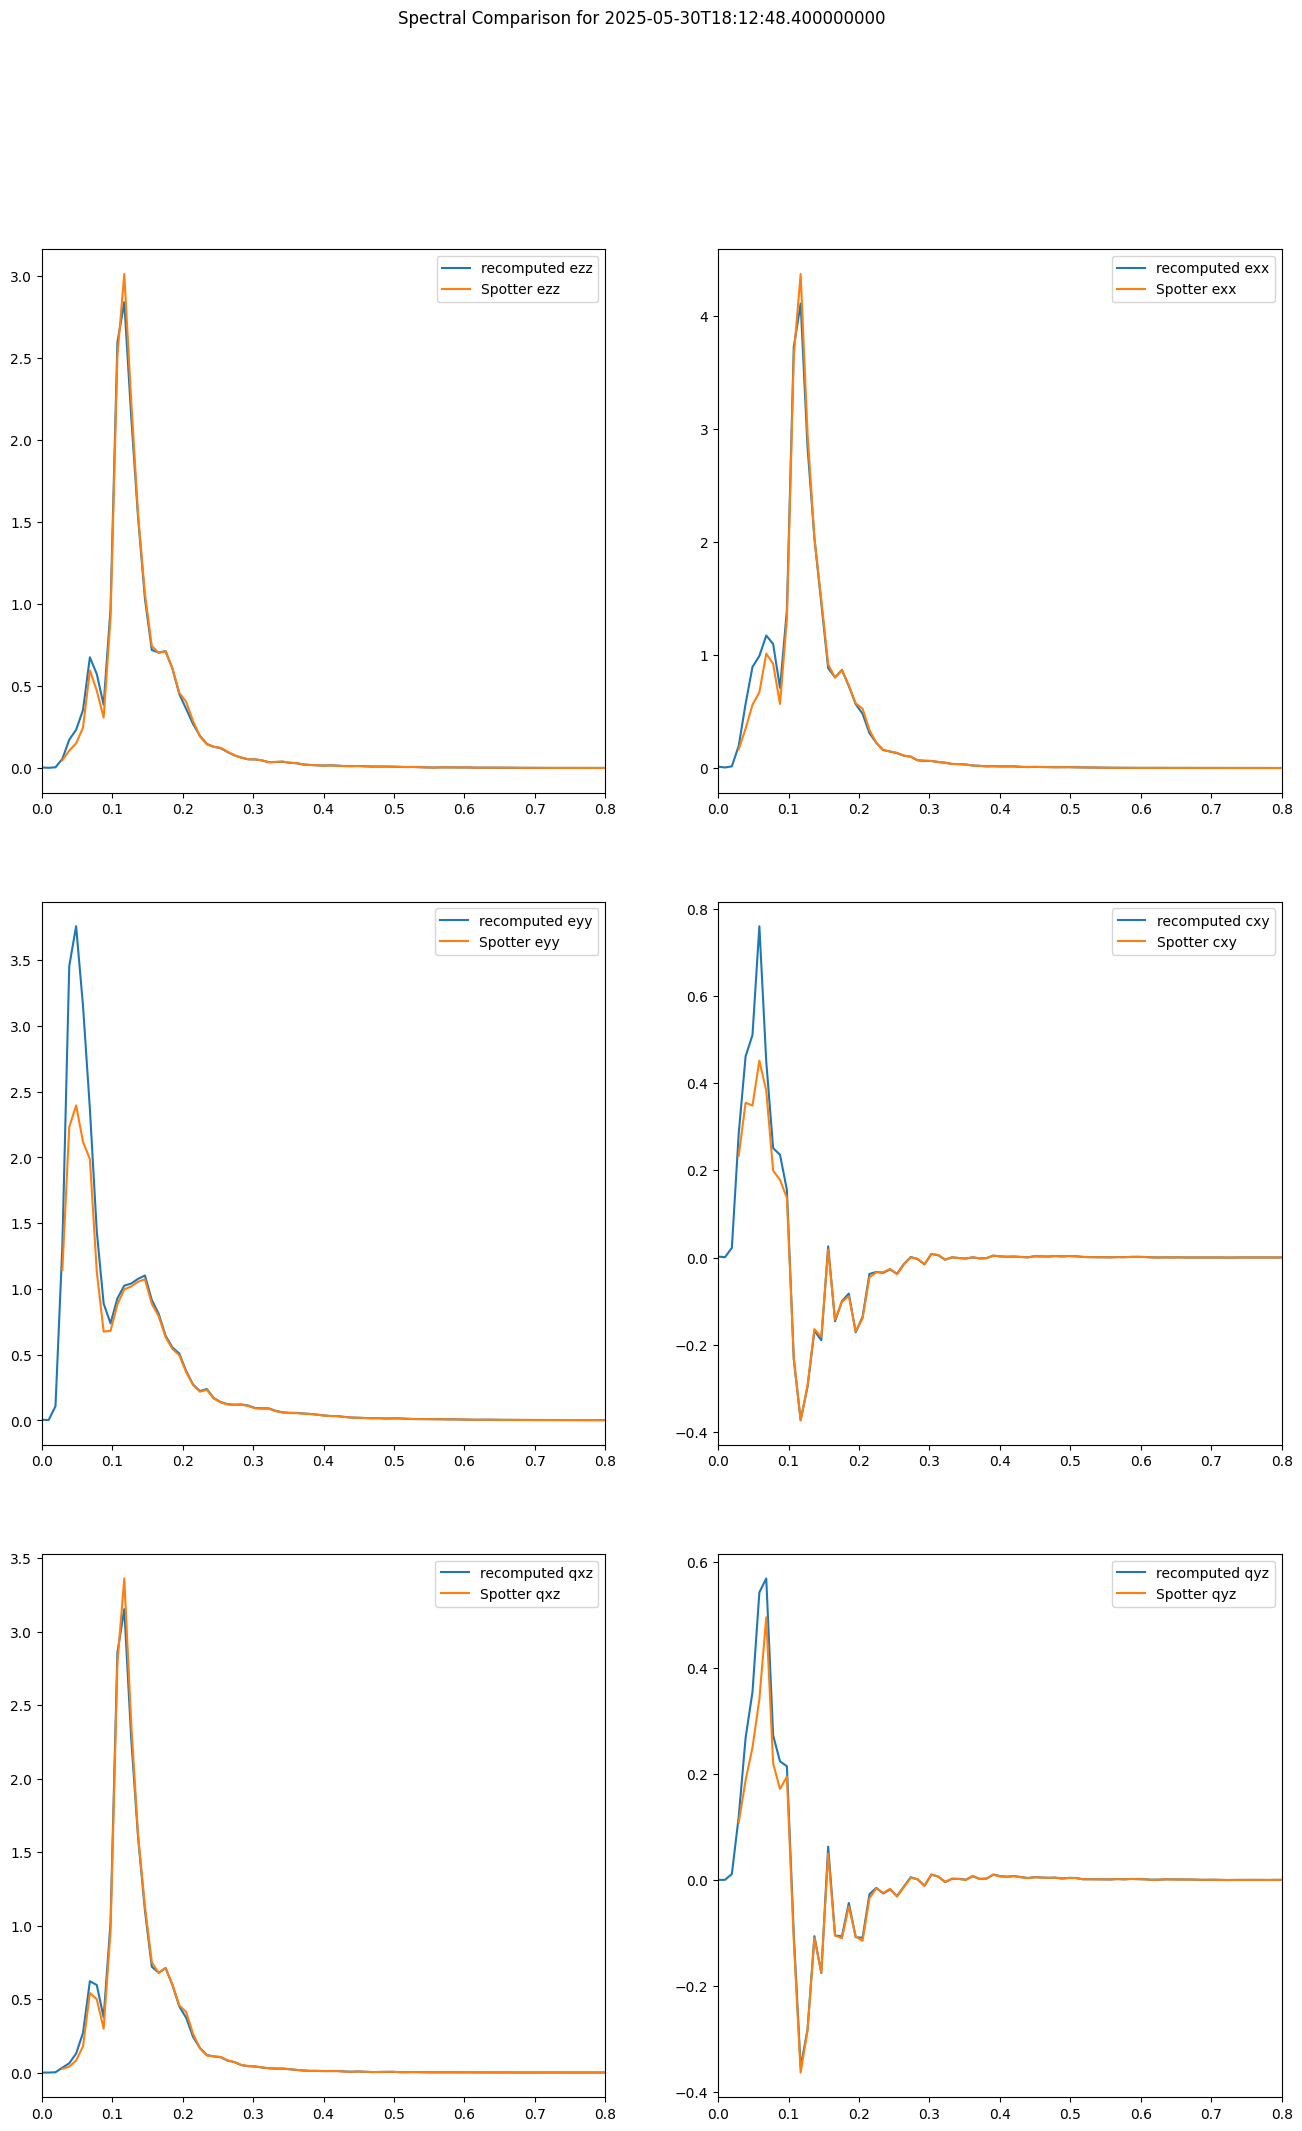

In [11]:
t_idx = 2 # this index was chosen as an example because it is a spectral density computed from a time series in which the Spotter was in the water for the entire hour, and thus is a nice comparison of the recomputed wave spectra to the Spotter firmware spectra.
fig, ax = plt.subplots(3, 2, figsize=(16, 24))

ax = ax.flatten()
ax[0].plot(spec.frequency, spec.ezz[t_idx,:], label='recomputed ezz')
ax[0].plot(spec.frequency[0:-1], ezz_arr[t_idx, 8::], label='Spotter ezz')
ax[0].legend()
ax[0].set_xlim([0, .8])

ax[1].plot(spec.frequency, spec.exx[t_idx, :], label='recomputed exx')
ax[1].plot(spec.frequency[0:-1], exx_arr[t_idx,8::], label='Spotter exx')
ax[1].legend()
ax[1].set_xlim([0, .8])

ax[2].plot(spec.frequency, spec.eyy[t_idx,:], label='recomputed eyy')
ax[2].plot(spec.frequency[0:-1], eyy_arr[t_idx,8::], label='Spotter eyy')
ax[2].legend()
ax[2].set_xlim([0, .8])

ax[3].plot(spec.frequency, spec.cxy[t_idx,:], label='recomputed cxy')
ax[3].plot(spec.frequency[0:-1], cxy_arr[t_idx,8::], label='Spotter cxy')
ax[3].legend()
ax[3].set_xlim([0, .8])

ax[4].plot(spec.frequency, spec.qxz[t_idx,:], label='recomputed qxz')
ax[4].plot(spec.frequency[0:-1], qxz_arr[t_idx,8::], label='Spotter qxz')
ax[4].legend()
ax[4].set_xlim([0, .8])

ax[5].plot(spec.frequency, spec.qyz[t_idx,:], label='recomputed qyz')
ax[5].plot(spec.frequency[0:-1], qyz_arr[t_idx,8::], label='Spotter qyz')
ax[5].legend()
ax[5].set_xlim([0, .8])

fig.suptitle(f'Spectral Comparison for {spec.time[t_idx]}')


In [13]:
# Now we can feed our Spectrum object (spec) into "compute_bulk_parameters" to recompute significant wave height, peak period, etc.

bulk_params = compute_bulk_parameters(spec)
fw_bulk_params = pd.read_csv(data_dir + 'bulkparameters.csv')
fw_bulk_params['time'] = format_csv_time(fw_bulk_params)

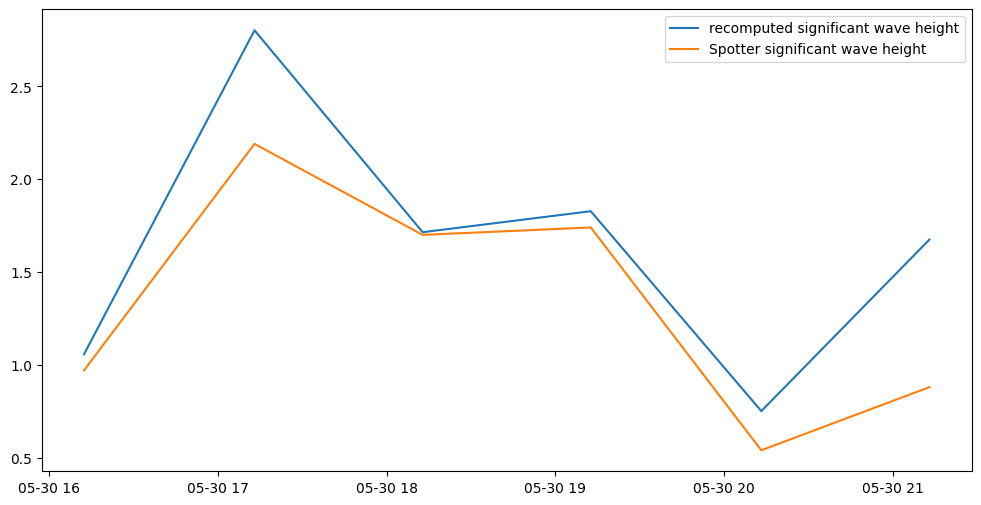

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(bulk_params.time, bulk_params.significant_wave_height, label='recomputed significant wave height')
plt.plot(fw_bulk_params.time, fw_bulk_params[' Significant Wave Height'], label='Spotter significant wave height')

plt.legend()